<a href="https://colab.research.google.com/github/arav-raval/Emerging_Artist_Prediction_ORF387/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install spotipy selenium pandas adjustText networkx matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.5/261.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 15.5 MB/s eta 0:00:00


In [53]:
# Import required libraries
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import re
import pprint
import json
import numpy as np
from adjustText import adjust_text
import os
from datetime import datetime
from google.colab import files

# **Spotify Authorization Workflow: Credential Setup**

In [3]:
# Define Spotify API credentials
CLIENT_ID = '829be16fb27f43fd98c2332fcd335f7e'
CLIENT_SECRET = '309db9acfc034e08bb93d646aa13a120'
REDIRECT_URI = 'https://google.com/'

# Define scope
scope = 'playlist-read-private playlist-read-collaborative'

# Create OAuth object without automatic opening
sp_oauth = SpotifyOAuth(client_id=CLIENT_ID,
                        client_secret=CLIENT_SECRET,
                        redirect_uri=REDIRECT_URI,
                        scope=scope,
                        show_dialog=True)

# Generate the authorization URL
auth_url = sp_oauth.get_authorize_url()

# Manually display the authorization URL
print(f"Open this URL to authorize: {auth_url}")

# Paste the URL you get after authorization
redirected_url = input("Paste the redirected URL here: ")

# Extract authorization code from URL
code = sp_oauth.parse_response_code(redirected_url)

# Get token from the code
token_info = sp_oauth.get_access_token(code)

# Set the authorized Spotify object
sp = spotipy.Spotify(auth=token_info['access_token'])

print("✅ Authorization successful!")

Open this URL to authorize: https://accounts.spotify.com/authorize?client_id=829be16fb27f43fd98c2332fcd335f7e&response_type=code&redirect_uri=https%3A%2F%2Fgoogle.com%2F&scope=playlist-read-private+playlist-read-collaborative&show_dialog=True
Paste the redirected URL here: https://www.google.com/?code=AQDrPCur-aGLQVFdlhopZbIUp-gb3gFl_oZQTUPEnus1zACjgy3jeSbvV4DHtiKgoid-yxQo2FmjpLTVnAatgShEtYLq0f-MmDUuUkoD3OPyXA5G3vicz1E1RYm0XyvKBjU9R03HWebd4CjjX2oQdibO_UmktTmYLswZ4b4KTDkByObF-xvPq2yUpITubfUrsq_OMnS5TzOsPlUFfLHuqRC93edlFLga0QsV
✅ Authorization successful!


<ipython-input-3-224d830c0db5>:29: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  token_info = sp_oauth.get_access_token(code)


# **Extracting Initial Artist Set**
This initial extraction only applies when using new playlists / creating the graph for the first time

In [4]:
# Get playlist tracks
def get_artists_from_playlist(playlist_id):
    results = sp.playlist_tracks(playlist_id)
    tracks = results['items']

    artist_list = []

    for item in tracks:
        track = item['track']
        for artist in track['artists']:
            artist_list.append(artist['name'])

    return list(set(artist_list))  # Remove duplicates

In [5]:
# Extract the playlist ID
# Spotify banned access to Featured playlists, so only using user-created playlists
def extract_playlist_id():
    url = input("Enter URL to your playlist (cannot be a Spotify Featured playlist)")
    match = re.search(r"playlist/([a-zA-Z0-9]+)", url)
    if match:
        return match.group(1)
    else:
        return None

In [6]:
playlist_id = extract_playlist_id()
if playlist_id:
    print("Playlist ID:", playlist_id)
    artist_list = get_artists_from_playlist(playlist_id)
    print(f"Found {len(artist_list)} unique artists in the playlist.")
    print(artist_list)
else:
    print("No playlist ID found.")

Enter URL to your playlist (cannot be a Spotify Featured playlist)https://open.spotify.com/playlist/1LDcLb8MX7Cq13DghRYNn9?si=78bad5e25e994200
Playlist ID: 1LDcLb8MX7Cq13DghRYNn9
Found 43 unique artists in the playlist.
['PARTYNEXTDOOR', 'Lola Young', 'Bad Bunny', 'Sabrina Carpenter', 'Playboi Carti', 'Alex Warren', 'Post Malone', 'The Weeknd', 'Lefty Gunplay', 'Kendrick Lamar', 'Gigi Perez', 'Drake', 'Teddy Swims', 'Tate McRae', 'Sexyy Red', 'Lil Wayne', 'Zach Bryan', 'Shaboozey', 'Selena Gomez', 'benny blanco', 'GloRilla', 'Alemán', 'Chappell Roan', 'Neton Vega', 'Doechii', 'Kacey Musgraves', 'ROSÉ', 'Yebba', 'Tyler, The Creator', 'Jimin', 'Morgan Wallen', 'Gracie Abrams', 'SZA', 'Arctic Monkeys', 'Benson Boone', 'Imogen Heap', 'Billie Eilish', 'The Marías', 'Lil Tecca', 'Lady Gaga', 'Kali Uchis', 'Don Toliver', 'Bruno Mars']


In [7]:
# Extract features for given artist
# Current features: id, popularity, followers, genres
def get_artist_features(artist):
  artist_info = sp.search(q='artist:' + artist, type='artist')['artists']['items'][0]
  info = {}
  info['ID'] = artist_info['id']
  info['Popularity'] = artist_info['popularity']
  info['Followers'] = artist_info['followers']['total']
  info['Genres'] = artist_info['genres']
  return info

In [8]:
# Extract all features about all artists in the given list
def update_features(artist_list, artist_dictionary={}):
  for artist in artist_list:
    # Add artist and relevant features if not already in dictionary
    if artist not in artist_dictionary.keys():
      artist_dictionary[artist] = get_artist_features(artist)
  return artist_dictionary

In [10]:
# Initializing artist graph and dictionary
artist_graph = nx.Graph()

# with open("artist_network.json", "r") as f:
#     artist_dictionary = json.load(f)

artist_dictionary = update_features(artist_list) #, artist_dictionary)

In [11]:
# Helper function for getting an artist's full discography
def get_artist_discography(artist_id):
  discography = {}
  album_offset = 0
  limit = 50
  while True:
    # Get all albums by the artist
    album_results = sp.artist_albums(artist_id, album_type='album', limit=limit, offset=album_offset)
    # Get all songs for each album
    for album in album_results['items']:
      track_offset = 0
      while True:
        track_results = sp.album_tracks(album['id'], limit=limit, offset=track_offset)
        for track in track_results['items']:
          discography[track['name']] = {}
          discography[track['name']]['Artists'] = track['artists']
          discography[track['name']]['Album'] = album['name']
          discography[track['name']]['Release Date'] = album['release_date']
          #discography[track['name']]['Popularity'] = track['popularity']

        # Paginate through tracks
        if track_results['next']:
          track_offset += limit
        else:
          break

    # Paginate through albums
    if album_results['next']:
      album_offset += limit
    else:
      break
  return discography

In [13]:
# Find related artists (featured on current artists' songs)
def get_related_artists(artist_list, artist_dictionary):
  artist_relations = {}
  for artist in artist_dictionary:
    artist_id = artist_dictionary[artist]['ID']
    artist_discography = get_artist_discography(artist_id)

    # Collect artists based on discography
    related_artists = []
    for track in artist_discography:
      # Collect related artists for a given artist
      for artist_info in artist_discography[track]['Artists']:
        #print("Artist: ", artist)
        #print("Related Artist: ", artist_info['name'])
        if artist_info['name'] != artist:
          related_artists.append(artist_info['name'])

      artist_relations[artist] = list(set(related_artists))
      # # Create relation between given artist and related artists
      # for artist_info in artist_discography[track]['Artists']:
      #   if artist_info['name'] in related_artists:
      #     artist_relations[artist] = artist_relations[artist] + related_artists
  return artist_relations

artist_relations = get_related_artists(artist_list, artist_dictionary)
print(json.dumps(artist_relations, indent=4))

{
    "PARTYNEXTDOOR": [
        "Drake",
        "Drake",
        "Drake",
        "Drake",
        "Drake",
        "Drake",
        "Pimmie",
        "Drake",
        "Drake",
        "Drake",
        "Drake",
        "Drake",
        "Drake",
        "Chino Pacas",
        "Drake",
        "Drake",
        "Yebba",
        "Drake",
        "Drake",
        "Drake",
        "Drake",
        "Drake",
        "Drake",
        "Nipsey Hussle",
        "Quavo",
        "Lil Yachty",
        "Murda Beatz",
        "DJ Candlestick",
        "OG Ron C",
        "DJ Candlestick",
        "OG Ron C",
        "DJ Candlestick",
        "OG Ron C",
        "DJ Candlestick",
        "OG Ron C",
        "DJ Candlestick",
        "OG Ron C",
        "DJ Candlestick",
        "OG Ron C",
        "DJ Candlestick",
        "OG Ron C",
        "DJ Candlestick",
        "OG Ron C",
        "Rihanna",
        "DJ Candlestick",
        "OG Ron C",
        "DJ Candlestick",
        "OG Ron C",
        "DJ

In [14]:
color_map = []


# Add all the related artists into the artist list and update features
related_artists = []
for artist in artist_relations:
  for related_artist in artist_relations[artist]:
    if related_artist not in artist_list and related_artist not in related_artists:
      print("Adding ", related_artist)
      related_artists.append(related_artist)

artist_list.extend(related_artists)
print("Newly added artists: ", related_artists)
print("Total artist list: ", artist_list)
artist_dictionary = update_features(artist_list, artist_dictionary)

# Assigning size of nodes by relative weights
weights = np.array([int(artist_dictionary[artist]['Followers']) for artist in artist_dictionary])
weights = weights / np.linalg.norm(weights)

# Add all artists into the graph
for index, artist in enumerate(artist_dictionary.keys()):
  artist_graph.add_node(artist, weights=weights[index])
  if artist in artist_relations.keys():
      color_map.append('blue') # Initial artist
  else:
    color_map.append('green') # Related node

# Create empty relations set for all artists
for artist in artist_dictionary:
  artist_dictionary[artist]['Related Artists'] = {}
  artist_dictionary[artist]['Related Artists']['Artist Collaboration'] = []

# Create vertices between artists for song collabs
for artist in artist_relations:
  if artist_relations[artist] != [] or artist_relations[artist] is not None:
    for related_artist in artist_relations[artist]:
      print("Adding edge between ", artist, " and ", related_artist)
      artist_graph.add_edge(artist, related_artist)

      # Add related artist to artist collabs
      if artist_dictionary[artist]['Related Artists']['Artist Collaboration'] == None:
        print("Adding ", related_artist)
        artist_dictionary[artist]['Related Artists']['Artist Collaboration'] = [related_artist]
      else:
        artist_dictionary[artist]['Related Artists']['Artist Collaboration'].append(related_artist)

      # Add artist to related artist collabs
      if artist_dictionary[related_artist]['Related Artists']['Artist Collaboration'] == None:
        artist_dictionary[related_artist]['Related Artists']['Artist Collaboration'] = [artist]
      else:
        artist_dictionary[related_artist]['Related Artists']['Artist Collaboration'].append(artist)

print("Entire updated artist dictionary")
print(json.dumps(artist_dictionary, indent=4))

Adding  Pimmie
Adding  Chino Pacas
Adding  Nipsey Hussle
Adding  Quavo
Adding  Lil Yachty
Adding  Murda Beatz
Adding  DJ Candlestick
Adding  OG Ron C
Adding  Rihanna
Adding  Halsey
Adding  Rick Ross
Adding  Travis Scott
Adding  Ca$h Out
Adding  RaiNao
Adding  Chuwi
Adding  Omar Courtz
Adding  Dei V
Adding  Los Pleneros de la Cresta
Adding  Young Miko
Adding  Mora
Adding  Bryant Myers
Adding  Luar La L
Adding  YOVNGCHIMI
Adding  Eladio Carrion
Adding  Feid
Adding  Arcángel
Adding  De La Ghetto
Adding  Ñengo Flow
Adding  Chencho Corleone
Adding  JHAYCO
Adding  Tony Dize
Adding  Rauw Alejandro
Adding  Bomba Estéreo
Adding  Buscabulla
Adding  Tainy
Adding  ROSALÍA
Adding  ABRA
Adding  Trio Vegabajeño
Adding  Zion & Lennox
Adding  Yandel
Adding  Don Omar
Adding  Nicky Jam
Adding  Gabriela
Adding  Daddy Yankee
Adding  Yaviah
Adding  Sech
Adding  Jowell & Randy
Adding  Anuel AA
Adding  Myke Towers
Adding  Kendo Kaponi
Adding  Duki
Adding  Pablo Chill-E
Adding  J Balvin
Adding  Marciano Canter

AttributeError: 'NoneType' object has no attribute 'append'

In [15]:
# Create empty relations set for all artists
for artist in artist_dictionary:
  artist_dictionary[artist]['Related Artists'] = {}
  artist_dictionary[artist]['Related Artists']['Artist Collaboration'] = []

# Create vertices between artists for song collabs
for artist in artist_relations:
  if artist_relations[artist] != [] or artist_relations[artist] is not None:
    for related_artist in artist_relations[artist]:
      print("Adding edge between ", artist, " and ", related_artist)
      artist_graph.add_edge(artist, related_artist)

      # Add related artist to artist collabs
      if artist_dictionary[artist]['Related Artists']['Artist Collaboration'] == None:
        print("Adding ", related_artist)
        artist_dictionary[artist]['Related Artists']['Artist Collaboration'] = [related_artist]
      else:
        artist_dictionary[artist]['Related Artists']['Artist Collaboration'].append(related_artist)

      # Add artist to related artist collabs
      if artist_dictionary[related_artist]['Related Artists']['Artist Collaboration'] == None:
        artist_dictionary[related_artist]['Related Artists']['Artist Collaboration'] = [artist]
      else:
        artist_dictionary[related_artist]['Related Artists']['Artist Collaboration'].append(artist)

print("Entire updated artist dictionary")
print(json.dumps(artist_dictionary, indent=4))

Adding edge between  PARTYNEXTDOOR  and  Drake
Adding edge between  PARTYNEXTDOOR  and  Drake
Adding edge between  PARTYNEXTDOOR  and  Drake
Adding edge between  PARTYNEXTDOOR  and  Drake
Adding edge between  PARTYNEXTDOOR  and  Drake
Adding edge between  PARTYNEXTDOOR  and  Drake
Adding edge between  PARTYNEXTDOOR  and  Pimmie
Adding edge between  PARTYNEXTDOOR  and  Drake
Adding edge between  PARTYNEXTDOOR  and  Drake
Adding edge between  PARTYNEXTDOOR  and  Drake
Adding edge between  PARTYNEXTDOOR  and  Drake
Adding edge between  PARTYNEXTDOOR  and  Drake
Adding edge between  PARTYNEXTDOOR  and  Drake
Adding edge between  PARTYNEXTDOOR  and  Chino Pacas
Adding edge between  PARTYNEXTDOOR  and  Drake
Adding edge between  PARTYNEXTDOOR  and  Drake
Adding edge between  PARTYNEXTDOOR  and  Yebba
Adding edge between  PARTYNEXTDOOR  and  Drake
Adding edge between  PARTYNEXTDOOR  and  Drake
Adding edge between  PARTYNEXTDOOR  and  Drake
Adding edge between  PARTYNEXTDOOR  and  Drake
Adding

737


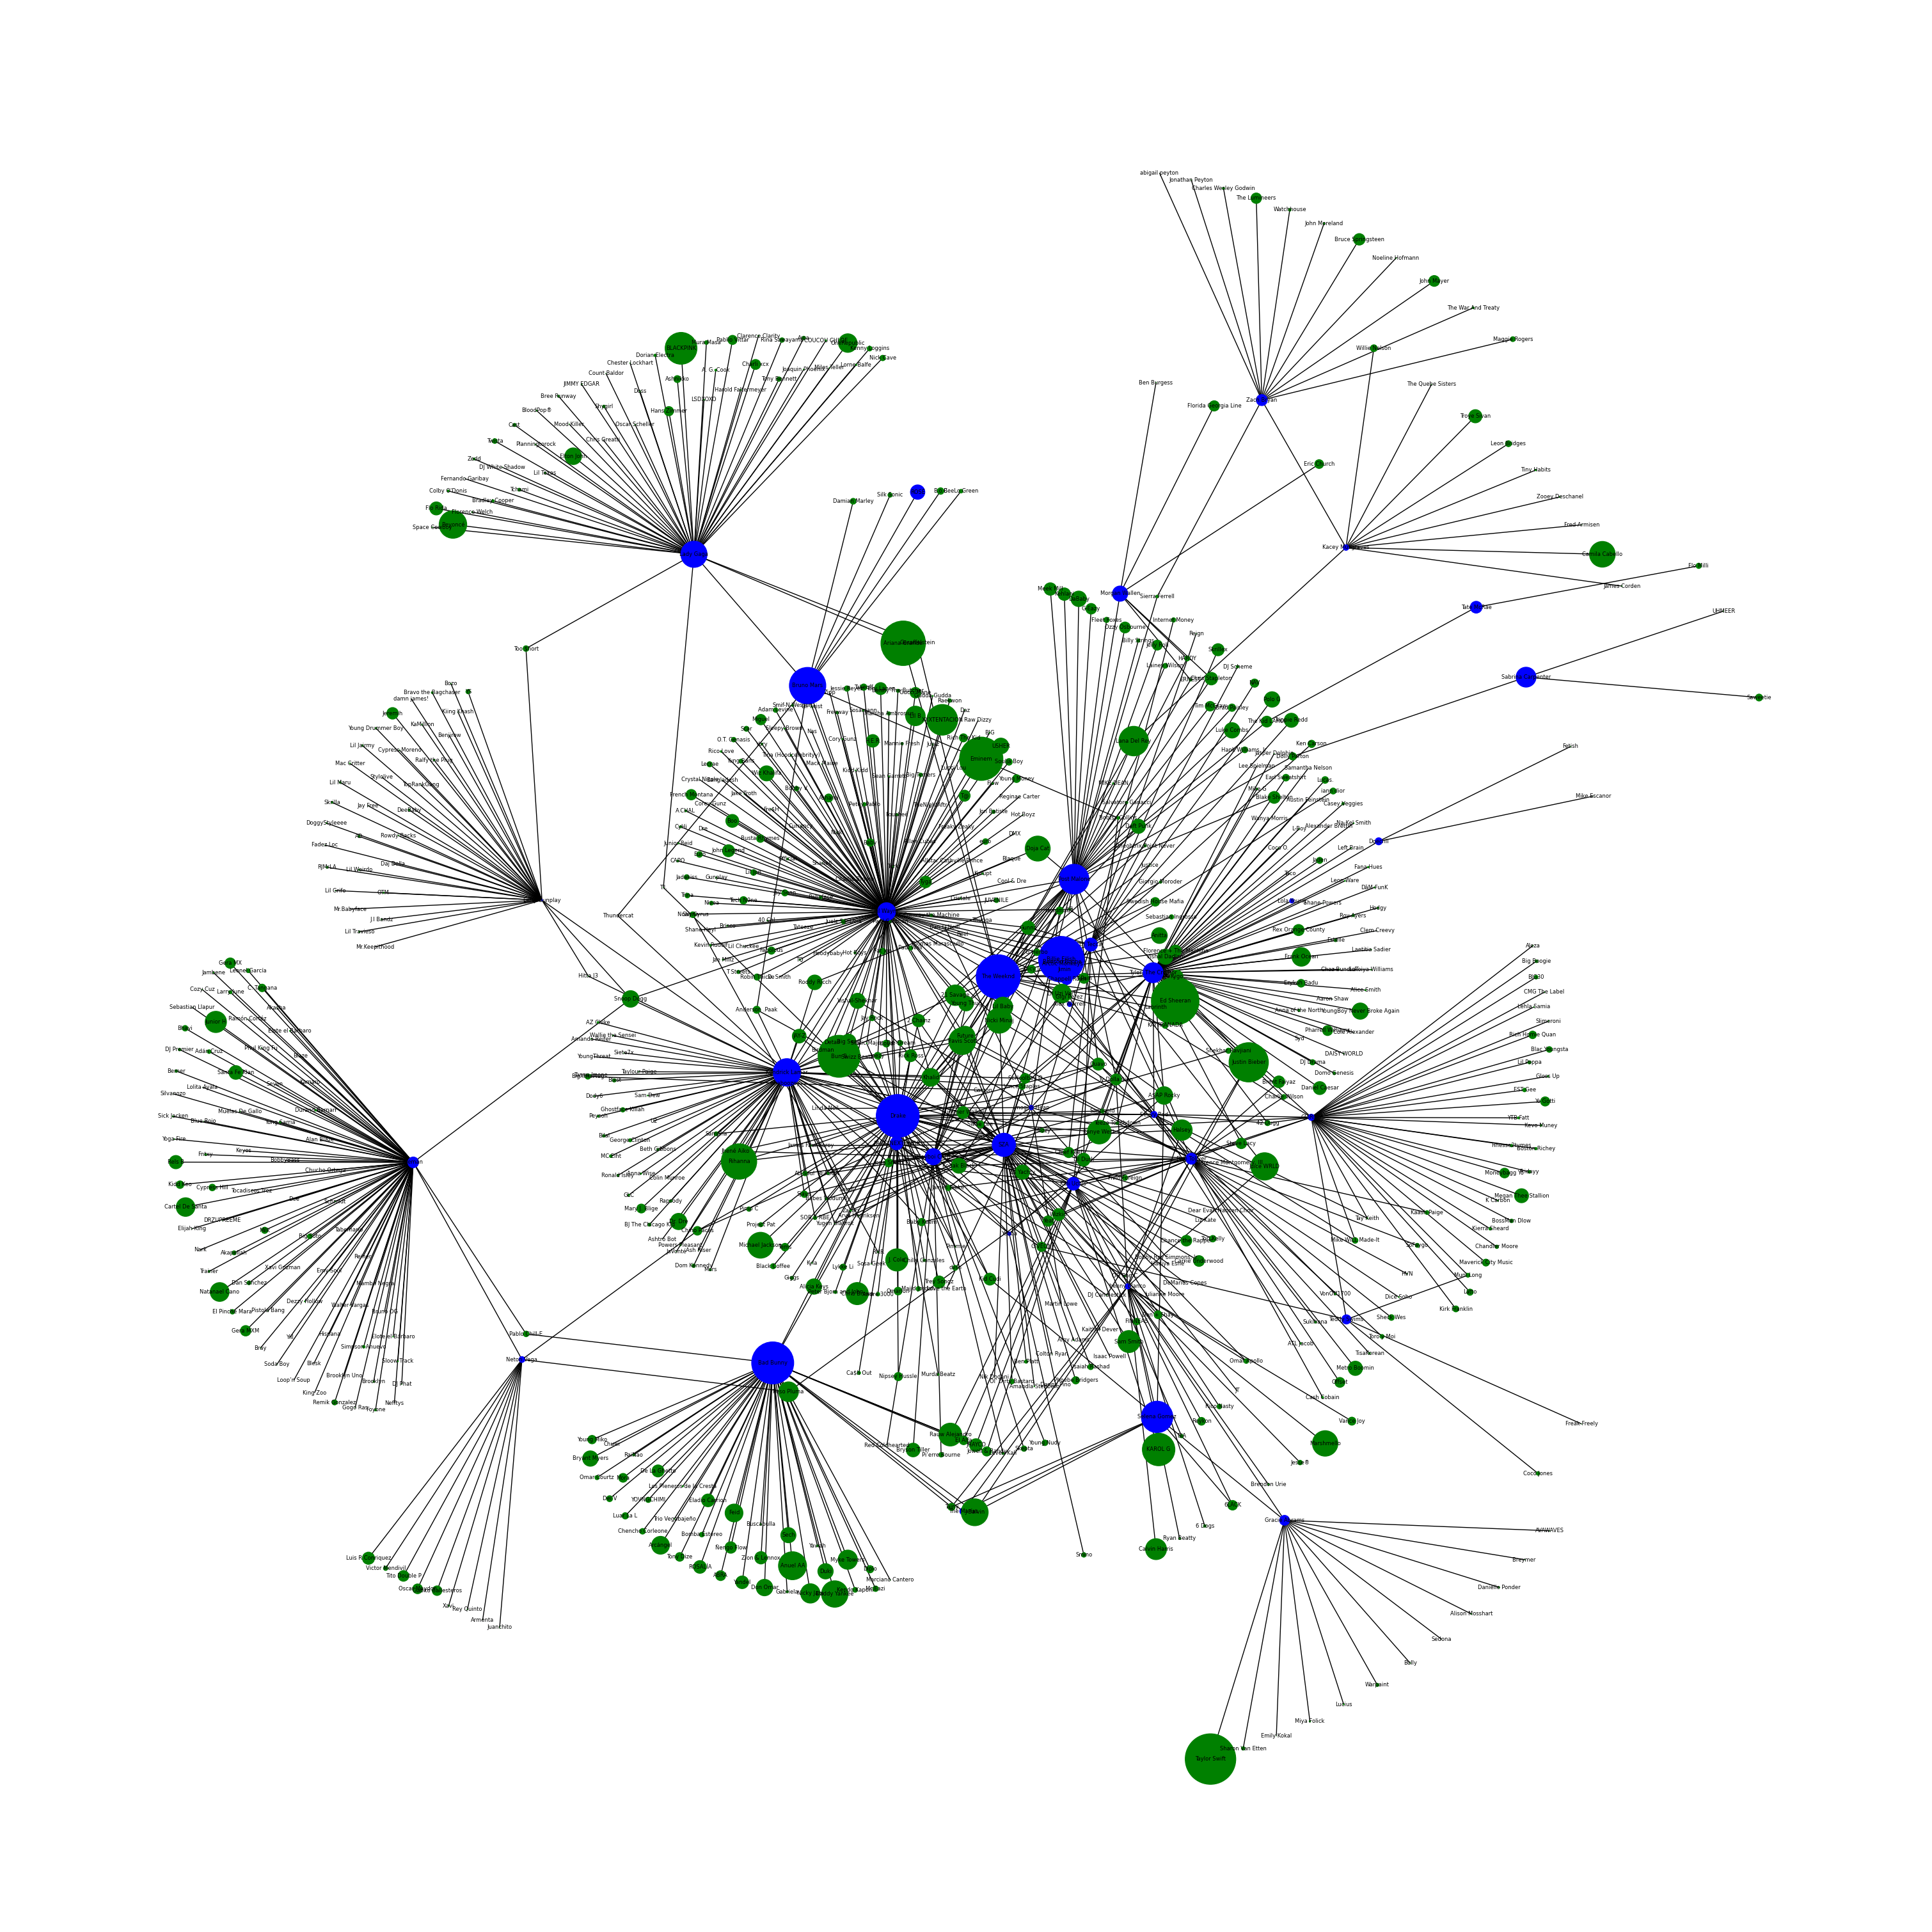

In [27]:
print(len(artist_list))
# Draw the graph
plot = plt.figure(figsize=(30,30))

# Use spring layout with adjusted k for more space
#pos = nx.spring_layout(artist_graph, k = 0.6)
#pos = nx.arf_layout(artist_graph)
pos = nx.kamada_kawai_layout(artist_graph)

# Draw nodes
nx.draw(artist_graph, pos, with_labels=False, node_size=weights*10e3, node_color=color_map)

# Add labels
labels = nx.draw_networkx_labels(artist_graph, pos, font_size=6)#, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Adjust overlapping text
# texts = list(labels.values())
# adjust_text(texts)

plot.show()

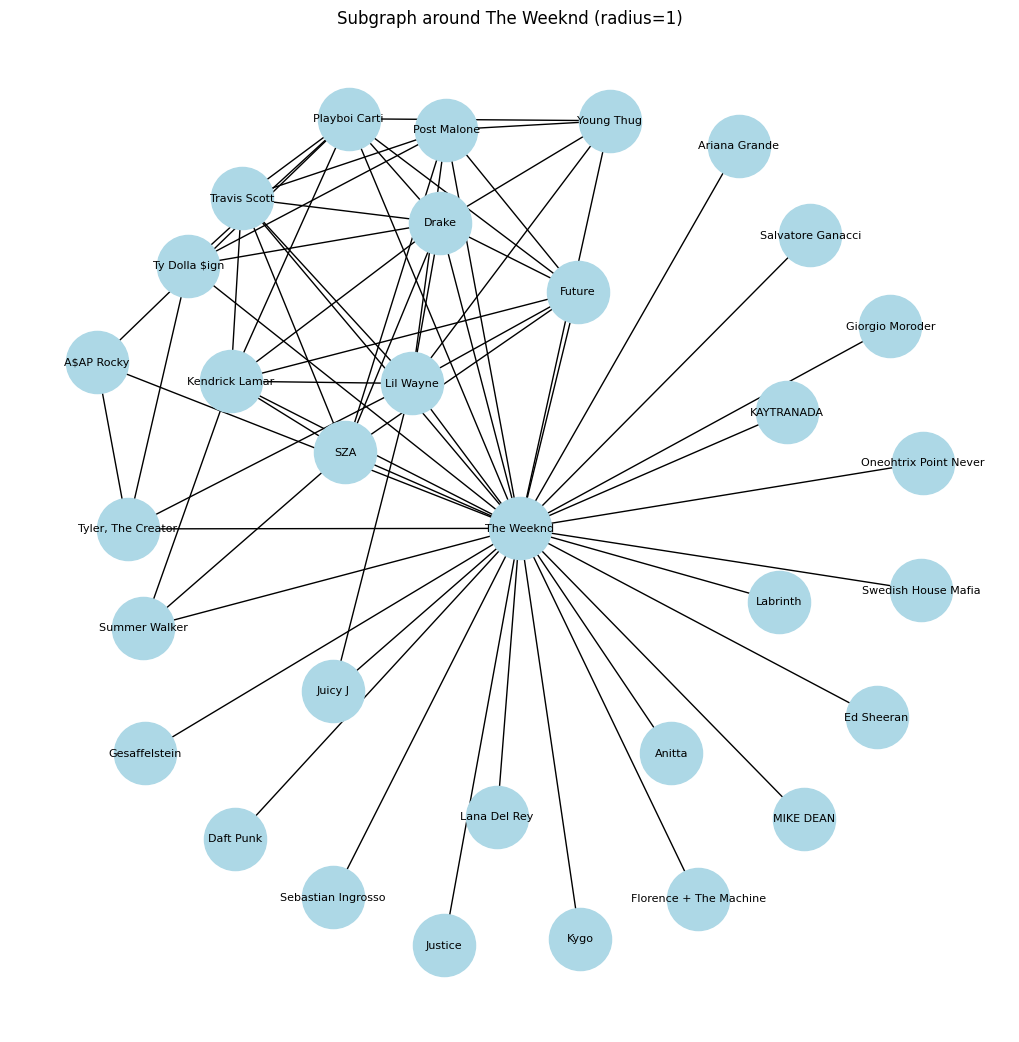

In [56]:
# Show a subgraph centered around the given artist
plt.figure(figsize=(10, 10))
artist = 'The Weeknd'
radius = 1
subgraph = nx.ego_graph(artist_graph, artist, radius=radius)

# Draw the subgraph
pos = nx.kamada_kawai_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_color="lightblue", node_size=2000, font_size=8)
plt.title(f"Subgraph around {artist} (radius={radius})")
plt.show()

In [54]:
# Store the exising graph into JSON
downloads_path = os.path.expanduser("~")
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

file_name = os.path.join(downloads_path,f"artist_network_{current_time}.json")

# Writing data to JSON file
with open(file_name, "w") as json_file:
    json.dump(artist_dictionary, json_file, indent=4)

files.download(file_name)
print(f"Data has been written to {file_name}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data has been written to /root/artist_network_2025-03-30_19-20-53.json
